In [1]:
import os,sys,inspect
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import vrpSolver
# %matplotlib notebook

## Solving TSP with different IP formulations

In this notebook, we are going to demostrate the efficiency of different IP formulations for solving the TSP. Including
- DFJ formulation
    - Lazy cut (when we find a violation of subtour constraint, add the lazy cut and go on)
    - Plain loop (when we find a violation of subtour constraint, restart the IP)
- MTZ formulation
- Multi-commodity formulation
- Shortest path formulation (or time-staged formulation)
- Quadratic formulation

### 0. Preparation
In this section, we will randomly generate TSP instances

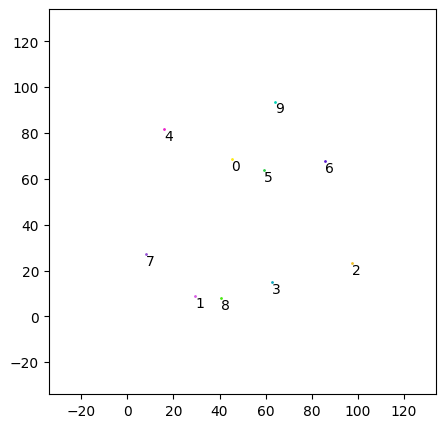

In [2]:
# Generate and plot instance
nodes = vrpSolver.rndNodes(
    N = 10,
    distr = 'UniformSquareXY',
    xRange = (0, 100),
    yRange = (0, 100)
)
fig, ax = vrpSolver.plotNodes(
    nodes = nodes, 
    boundingBox = (-20, 120, -20, 120)
)

### 1. DFJ formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V \label{TSP:con:degree1}\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V \label{TSP:con:degree2}\\
				      & \sum_{j\notin S, i\in S, (i,j)\in A} x_{ij} \ge 1, \quad \forall S \subset V, 2\le |S| \le n-1 \label{TSP:con:DFJSubtour1}\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A   
\end{align}




In [3]:
# DFJ with lazy cut
DFJ_Lazy = vrpSolver.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'DFJ_Lazy',
    solver = 'Gurobi',
    detailsFlag = False,
    outputFlag = False)

In [4]:
DFJ_Lazy

{'ofv': 310.831904519416,
 'seq': [0, 4, 7, 1, 8, 3, 2, 6, 9, 5, 0],
 'gap': 0,
 'solType': 'IP_Optimal',
 'lowerBound': 310.831904519416,
 'upperBound': 310.831904519416,
 'runtime': 0.0039882659912109375}

In [5]:
# Plot the result of TSP
fig, ax = vrpSolver.plotNodeSeq(
    fig = fig,
    ax = ax,
    nodes = nodes, 
    nodeSeq = DFJ_Lazy['seq'])

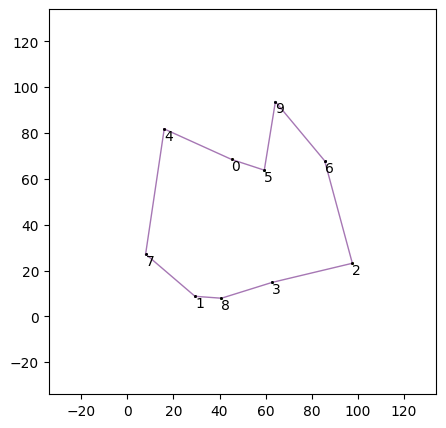

In [6]:
fig

In [8]:
# DFJ with plain loop
DFJ_Plainloop = vrpSolver.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'DFJ_Plainloop',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 3)
print(DFJ_Plainloop)

{'ofv': 310.83190451941607, 'seq': [0, 5, 9, 6, 2, 3, 8, 1, 7, 4, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 310.83190451941607, 'upperBound': 310.83190451941607, 'runtime': 0.0035724639892578125}


The following figure shows the result for TSP, since every formulation will yield to the same result, we are not going to repeat this part

### 2. MTZ formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

Define $t_i$ as the time of visisting vertex $i$

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V\\
					  & t_i + \tau_{ij} \le t_j  + M(1 - x_{ij}), \quad i, j = 2, \cdots, n \in V, (i, j) \in A\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A\\
					  & t_i \ge 0, \quad i \in 1, \cdots, n \in V
\end{align}


In [9]:
# MTZ
MTZ = vrpSolver.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'MTZ',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 10)
print(MTZ)

{'ofv': 310.83190451941607, 'seq': [0, 5, 9, 6, 2, 3, 8, 1, 7, 4, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 310.83190451941607, 'upperBound': 310.83190451941607, 'runtime': 0.016170501708984375}


### 3. Multi-Commodity flow formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

Define $y_{ij}^k$ as commodity flow for the $k$th commodity when traveling through edge $(i, j)$

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V\\
					  & y_{ij}^k \le x_{ij}, \quad \forall i, j, k \in N, k \neq 1\\
					  & \sum_{i \in V} y_{1i}^k = 1, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{i1}^k = 0, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{ik}^k = 1, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{j \in V} y_{kj}^k = 0, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{ij}^k - \sum_{i \in V} y_{ji}^k = 0, \quad \forall j, k \in V \setminus \{1\}, j \neq k\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A\\
                      & y_{ij}^k \in \mathbb{Z}, \quad \forall i, j, k \in N, k \neq 1\\
\end{align}


In [10]:
# MultiCommodityFlow
MultiCommodityFlow = vrpSolver.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'MultiCommodityFlow',
    solver = 'Gurobi',
    outputFlag = False)
print(MultiCommodityFlow)

{'ofv': 310.831904519416, 'seq': [0, 4, 7, 1, 8, 3, 2, 6, 9, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 310.831904519416, 'upperBound': 310.831904519416, 'runtime': 0.0176849365234375}


### 4. Shortest path formulation (time-staged formulation)

Define $x_{ij}^t$ as the following

\begin{equation}
    x_{ij}^t = \begin{cases}
                    1, \quad \text{If path crosses arc } (i, t) \text{ and } (j, t + 1) \\
                    0, \quad \text{Otherwise}
                \end{cases}, \quad i \in V, j \in V \setminus \{i\}, t = 1, \cdots, n
\end{equation}

IP formulation:

\begin{align}
    \min \quad &\sum_{i \in V}\sum_{j \in V\setminus \{i\}} c_{ij} \sum_{t = 1}^n x_{ij}^t\\
    \text{s.t.} \quad &\sum_{j \in V \setminus \{1\}} x_{1j}^1 = 1\\
    &\sum_{j \in V \setminus \{1, i\}} x_{ij}^2 - x_{1i}^1 = 0, \quad \forall i \in V \setminus \{1\} \\
    &\sum_{j \in V \setminus \{1, i\}} x_{ij}^t - \sum_{j \in V \setminus \{1, i\}} x_{ji}^{t - 1} = 0, \quad \forall i \in V \setminus \{1\}, t \in \{2, \dots, n - 1\}\\
    &x_{i1}^n - \sum_{j \in V \setminus \{1, i\}} x_{ji}^{n - 1} = 0, \quad \forall i \in V \setminus \{1\} \\
    &\sum_{i \in V \setminus \{1\}} x_{i1}^n = 1\\
    &\sum_{t = 2}^{n - 1}\sum_{j \in V \setminus \{1, i\}} x_{ij}^t + x_{i1}^n \le 1, \quad \forall i \in V \setminus \{1\}\\ 
    &x_{1i}^1 + \sum_{t = 2}^{n - 1}\sum_{j \in V \setminus \{1, i\}} x_{ji}^t \le 1, \quad \forall i \in V \setminus \{1\}\\
\end{align}

In [11]:
# ShortestPath
ShortestPath = vrpSolver.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'ShortestPath',
    solver = 'Gurobi',
    outputFlag = False)
print(ShortestPath)

{'ofv': 310.831904519416, 'seq': [0, 4, 7, 1, 8, 3, 2, 6, 9, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 310.831904519416, 'upperBound': 310.831904519416, 'runtime': 0.023494720458984375}


### 5. Quadratic formulation

Assuming we have $n$ boxes, which represents $n$ steps in the path. Define $x_{ij}$ as 

\begin{equation}
    x_{ij} = \begin{cases}
                1, \quad \text{Vertex $i$ is assigned to box $j$}\\
                0, \quad \text{Otherwise}
            \end{cases}
\end{equation}

IP formulation:

\begin{align}
    \min \quad & \sum_{i \in V} \sum_{j \in V \setminus \{i\}} \sum_{k = 1}^{n - 1} c_{ij} w_{ij}^k + \sum_{i \in V} \sum_{j \in V \setminus \{i\}} c_{ij}w_{ij}^n\\
    \text{s.t.} \quad & \sum_{j = 1}^n x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V}^n x_{ij} = 1, \quad j = 1, \dots, n\\
                      & w_{ij}^k \ge x_{ik} + x_{j, k + 1} - 1, \quad i \in V,  j \in V \setminus \{i\}, k = 1, \cdots, n - 1\\
                      & w_{ij}^k \ge x_{ik} + x_{j1} - 1, \quad i \in V, j \in V \setminus \{i\}, k = n \\
                      & w_{ij}^k \in \{0, 1\}, \quad i \in V, j \in V \setminus \{i\}, k = 1, \dots, n\\
                      & x_{ij} \in \{0, 1\}, \quad i \in V, j \in V \setminus \{i\}
\end{align}

In [12]:
# QAP
QAP = vrpSolver.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'QAP',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 15)
print(QAP)

{'ofv': 310.831904519416, 'seq': [0, 4, 7, 1, 8, 3, 2, 6, 9, 5, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 310.831904519416, 'upperBound': 310.831904519416, 'runtime': 3.584096908569336}


In [13]:
InsertionAnd2Opt = vrpSolver.solveTSP(
    nodes = nodes,
    edges = 'Euclidean',
    algo = 'Heuristic',
    cons = 'NearestNeighbor',
    impv = '2Opt')

TypeError: _heuTSP() missing 1 required positional argument: 'nodeIDs'

In [9]:
InsertionAnd2Opt

{'ofv': 978.7259777023226,
 'seq': [0,
  131,
  17,
  109,
  145,
  58,
  86,
  117,
  3,
  55,
  121,
  126,
  92,
  20,
  129,
  67,
  101,
  26,
  34,
  107,
  62,
  147,
  10,
  4,
  56,
  148,
  39,
  113,
  146,
  119,
  87,
  53,
  21,
  33,
  116,
  106,
  22,
  48,
  50,
  83,
  98,
  84,
  99,
  74,
  102,
  54,
  31,
  18,
  134,
  72,
  46,
  57,
  8,
  70,
  16,
  115,
  127,
  110,
  137,
  135,
  79,
  136,
  52,
  85,
  149,
  37,
  71,
  6,
  125,
  11,
  13,
  142,
  30,
  93,
  15,
  42,
  112,
  7,
  65,
  132,
  38,
  78,
  82,
  77,
  91,
  138,
  68,
  12,
  124,
  69,
  141,
  118,
  44,
  36,
  123,
  122,
  114,
  25,
  32,
  103,
  43,
  61,
  100,
  75,
  76,
  111,
  81,
  95,
  49,
  66,
  130,
  88,
  143,
  51,
  29,
  23,
  140,
  1,
  89,
  73,
  2,
  59,
  120,
  47,
  105,
  60,
  144,
  41,
  9,
  97,
  27,
  133,
  64,
  40,
  96,
  19,
  45,
  104,
  108,
  128,
  35,
  90,
  14,
  80,
  5,
  63,
  139,
  94,
  24,
  28,
  0]}